In [1]:

pip install tensorflow_text

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import sklearn.preprocessing
import json
import warnings

2024-08-07 14:26:21.056692: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 14:26:21.056834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 14:26:21.238056: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
warnings.filterwarnings('ignore')

In [4]:
EPOCHS = 10
BATCH_SIZE = 64

In [5]:
df = pd.read_csv('Symptom2Disease.csv')
df.drop('Unnamed: 0', axis='columns', inplace=True)
df['label'] = df['label'].apply(lambda x: x.title())
df.head(2)

,label,text
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."


In [6]:
label_binarizer = sklearn.preprocessing.LabelBinarizer()
df = df.join(pd.DataFrame(label_binarizer.fit_transform(df['label']),
                         columns=label_binarizer.classes_,
                         index=df.index
                         ))
df.drop('label', axis='columns', inplace=True)
df.head(2)

,text,Acne,Allergy,Arthritis,Bronchial Asthma,Cervical Spondylosis,Chicken Pox,Common Cold,Dengue,Diabetes,...,Impetigo,Jaundice,Malaria,Migraine,Peptic Ulcer Disease,Pneumonia,Psoriasis,Typhoid,Urinary Tract Infection,Varicose Veins
0,I have been experiencing a skin rash on my arm...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,"My skin has been peeling, especially on my kne...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [7]:
val_df = df.sample(frac=0.2)
train_df = df.drop(val_df.index)

print(f'Training Dataset Size: {len(train_df)}', f'Validation Dataset Size: {len(val_df)}', sep='\n')


Training Dataset Size: 960
Validation Dataset Size: 240


In [8]:
def dataframe_to_tf_dataset(dataframe):
    dataframe = dataframe.copy()
    feature = dataframe.pop('text')
    ds = tf.data.Dataset.from_tensor_slices((feature, dataframe))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [9]:
train_ds = dataframe_to_tf_dataset(train_df).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
val_ds = dataframe_to_tf_dataset(val_df).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [10]:
# Define input layer
text_input = tf.keras.Input(shape=(), name='text', dtype='string')

# Define preprocessing layer
preprocessor = hub.KerasLayer(
    'https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3',
    name='bert_preprocessor'
)

# Process input through preprocessing layer
encoder_inputs = preprocessor(text_input)

# Define BERT encoder layer
encoder = hub.KerasLayer(
    'https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-6-h-128-a-2/versions/2',
    trainable=True,
    name='bert_encoder'
)

# Pass processed input through encoder
outputs = encoder(encoder_inputs)

# Get the pooled output from the encoder
pooled_output = outputs['pooled_output']

# Apply dropout layer
x = tf.keras.layers.Dropout(0.20, name='dropout')(pooled_output)

# Define dense output layer with softmax activation function
outputs = tf.keras.layers.Dense(24, activation='softmax', name='output')(x)

Attaching model 'tensorflow/bert/tensorflow2/en-uncased-preprocess/3' to your Kaggle notebook...
Attaching model 'tensorflow/bert/tensorflow2/bert-en-uncased-l-6-h-128-a-2/2' to your Kaggle notebook...


In [11]:
model = tf.keras.Model(text_input, outputs, name='medaid')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "medaid"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 bert_preprocessor (KerasLa  {'input_type_ids': (None,    0         ['text[0][0]']                
 yer)                        128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                             

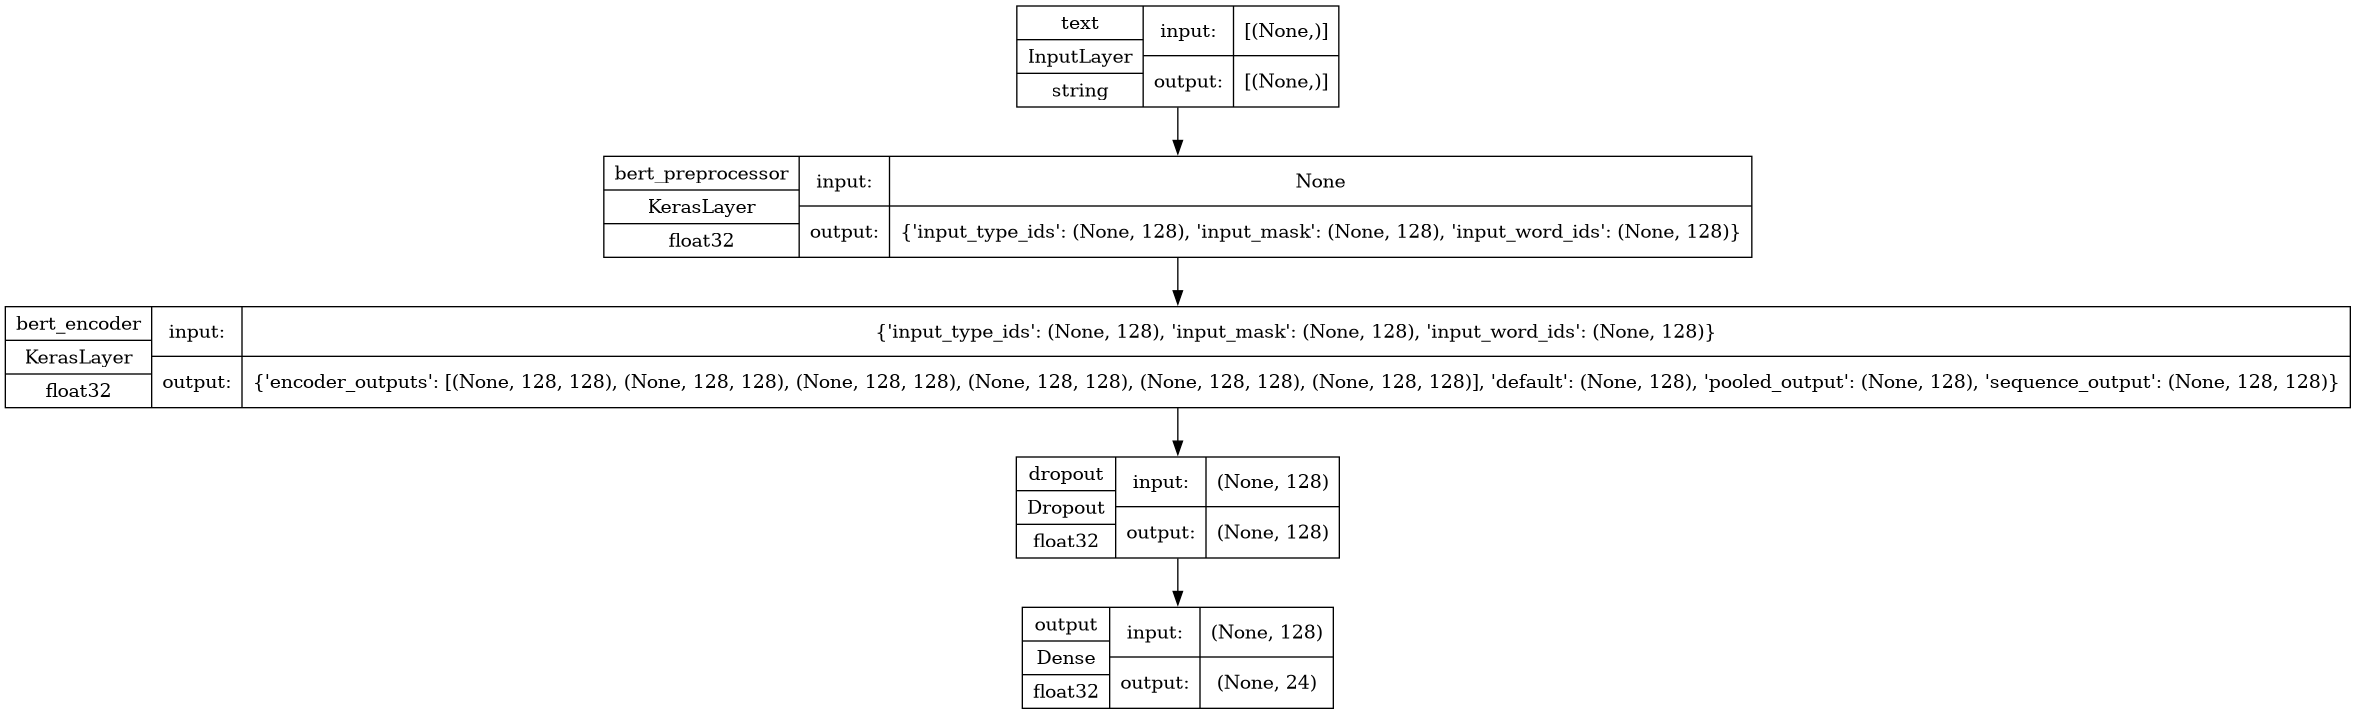

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [ ]:
model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15


In [ ]:
model.save('/kaggle/working/model.keras')

In [ ]:
classes = label_binarizer.classes_
classes_dict = {i: v for i, v in enumerate(classes)}
with open('/kaggle/working/classes.json', 'w') as file:
    json.dump(classes_dict, file)

In [ ]:
def predict(text):
#     print(f"Predicting for text: {text}")  # Debugging statement
    feature = {'text': text}
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in feature.items()}
    predictions = model.predict(input_dict, verbose=0)[0]
    classes = label_binarizer.classes_
    predictions_dict = {}

    for i in range(len(classes)):
        predictions_dict[classes[i]] = predictions[i] * 100
    
    # Check if predictions_dict is not empty
    if not predictions_dict:
        print("Warning: predictions_dict is empty!")
        return None
    
    # Sort predictions_dict and return
    predictions_dict = {k: v for k, v in sorted(predictions_dict.items(), key=lambda item: item[1], reverse=True)}
    return predictions_dict


# predict("hii")


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the true labels from val_df (converting one-hot encoding to class indices)
true_labels = np.argmax(val_df.iloc[:, 1:], axis=1)

# Extract the text inputs for predictions
text_inputs = val_df.iloc[:, 0].values

# Initialize an empty list to hold the predicted labels
predicted_labels = []

# Loop through the text inputs to get predictions
for text in text_inputs:
    # Get the predictions for the given text
    predictions_dict = predict(text)
    
    if predictions_dict:
        # Get the class with the highest probability
        predicted_class = max(predictions_dict, key=predictions_dict.get)
        # Convert class name to index
        predicted_label_index = list(label_binarizer.classes_).index(predicted_class)
        predicted_labels.append(predicted_label_index)
    else:
        # Handle case where predictions_dict is None
        predicted_labels.append(None)

# Convert predicted_labels list to a numpy array
predicted_labels = np.array(predicted_labels)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_binarizer.classes_, yticklabels=label_binarizer.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report

cm = confusion_matrix(true_labels, predicted_labels)

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision, recall, and F1-score for each class
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print evaluation measures
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-score (weighted): {f1:.4f}")

# Optional: Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))

# Plotting the confusion matrix using seaborn heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(true_labels),
            yticklabels=np.unique(true_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
